In [1]:
import requests as rq
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from pipeline import *

In [2]:
start_time = "2021-07-22 00:00:00"
end_time = "2021-07-29 00:00:00"
params = {
    'DataSet': 'SGWL.Working@OW283',
    'StartTime': start_time,
    'EndTime': end_time,
    'ExportFormat': 'csv',
    'Compressed': 'false',
    'RoundData': 'False',
    'Unit': '306',
    'Timezone': '-7', 
}

token = rq.post(url = f"https://aqrt.nrs.gov.bc.ca/Export/DataSetToken", params=params).json()["Token"]
params['Token'] = token.replace('+', '%2B').replace('/', r'%2F')
response = rq.get(url = f"https://aqrt.nrs.gov.bc.ca/Export/DataSet", params=params)
reader = list(csv.reader(response.text.splitlines()))

In [3]:
cleaned = np.transpose(tuple(filter(lambda x: x, map(lambda x: clean_and_process(x[0], x[1], x[3]), reader))))

In [4]:
with open("data/dataset.csv") as data:
    parsed = filter(lambda x: x, map(lambda x: clean_and_process(x[0], x[1], x[3]), csv.reader(data)))
    split = year_splitter(parsed)
    years = list(map(lambda x: np.transpose(unify_year(x)), split))

In [5]:
def rolling_mean(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

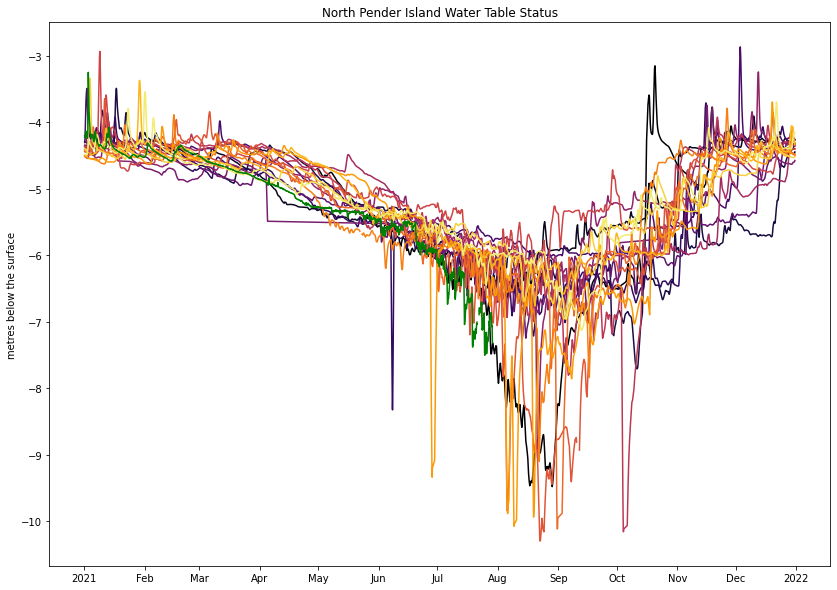

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)

ax.set_ylabel("metres below the surface")
ax.set_title("North Pender Island Water Table Status")

locator = mdates.AutoDateLocator(minticks=3, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

colourmap = cm.get_cmap('inferno')

year_plots = []

for i, year in enumerate(years[:-1]):
    year_as_percentage = i/(2021-2003)
    (year_plot, ) = ax.plot(year[0][:-24], rolling_mean(year[1], 24)[:-24], color=colourmap(year_as_percentage))
    year_plot
    year_plots.append(year_plot)
ax.plot(years[-1][0], years[-1][1], color="green")